In [143]:
import numpy as np # generic math functions
import math
import matplotlib.pyplot as plt
import os, glob
import pickle
import seaborn as sns
import random
from time import time

from quspin.operators import hamiltonian # Hamiltonians and operators
from quspin.basis import spinless_fermion_basis_1d, tensor_basis # Hilbert space fermion and tensor bases
from quspin.basis import spinful_fermion_basis_1d

from modules.SYK import *
from modules.pluckers import *


%load_ext autoreload
%autoreload 2
sns.set(style="whitegrid", context="talk", font_scale=1.0, palette=sns.color_palette("bright"), color_codes=False)
plt.rcParams["figure.figsize"] = (9,6)

folder_for_figures = 'results_SYK/figures_SYK/'
folder_for_data = 'results_SYK/data_SYK/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Pluckers

In [139]:
number_of_realizations = 1
L = 12
Nf = 11
J = 1
label = 'bulk'

if label== 'GS':
    level = 0
    
    filename_pluckers_gen = folder_for_data + 'Plucker_GS_J={}_L={}_Nf={}'.format(J, L, Nf)
    filename_spectrums_gen = folder_for_data + 'Spectrum_GS_J={}_L={}_Nf={}'.format(J, L, Nf)

    for realization in range(number_of_realizations):
        print('It is {} realization'.format(realization))
        basis, E, V = solve_SYK_Hamiltonian(L, Nf, J, 0)
        Pluckers_temp = PluckersSpinless(min(Nf, L-Nf), basis, np.transpose(V)[level])

        identifyer = random.randint(0, 1000000000)
        filename_Plucker = filename_pluckers_gen + '_{}.pkl'.format(identifyer)
        filename_Spectrum = filename_spectrums_gen + '_{}.pkl'.format(identifyer)
        with open(filename_Spectrum, 'wb') as f_E:
            pickle.dump(E, f_E)
        with open(filename_Plucker, 'wb') as f_P:
            pickle.dump(Pluckers_temp, f_P)
            
if label== 'bulk':
    
    basis = spinless_fermion_basis_1d(L=L,Nf=Nf)
    level = basis.Ns//2

    filename_pluckers_gen = folder_for_data + 'Plucker_bulk_J={}_L={}_Nf={}'.format(J, L, Nf)
    filename_spectrums_gen = folder_for_data + 'Spectrum_bulk_J={}_L={}_Nf={}'.format(J, L, Nf)

    
    for realization in range(number_of_realizations):
        print('It is {} realization'.format(realization))
        basis, E, V = solve_SYK_Hamiltonian(L, Nf, J, 0)
        Pluckers_temp = PluckersSpinless(min(Nf, L - Nf), basis, np.transpose(V)[level])
        Pluckers_temp = np.hstack(( Pluckers_temp, np.zeros(Nf + 1 - len(Pluckers_temp))))

        identifyer = random.randint(0, 1000000000)
        filename_Plucker = filename_pluckers_gen + '_{}.pkl'.format(identifyer)
        filename_Spectrum = filename_spectrums_gen + '_{}.pkl'.format(identifyer)
        with open(filename_Spectrum, 'wb') as f_E:
            pickle.dump(E, f_E)
        with open(filename_Plucker, 'wb') as f_P:
            pickle.dump(Pluckers_temp, f_P)

It is 0 realization
we are calculating 0 Plucker and it is 1.0000003147138639
we are calculating 1 Plucker and it is -4.85722573273506e-17


#### Reading out and averaging

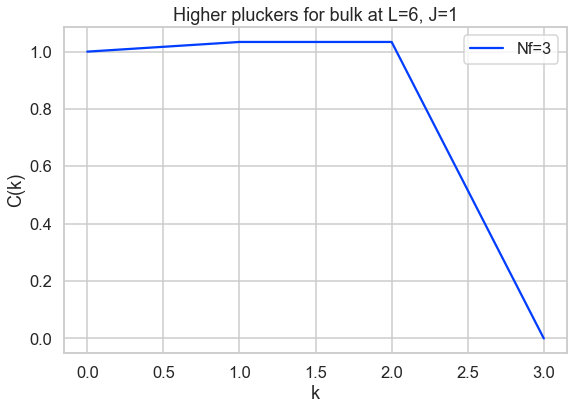

In [73]:
L = 6
Nf = L//2
J = 1
label = "bulk"

cwd = os.getcwd()
destdir = cwd + '/' +  folder_for_data
files = [ f for f in os.listdir(destdir) if os.path.isfile(os.path.join(destdir,f)) ]

if label=="GS":
    Plucker_files = [f for f in files if f[0] == 'P' and f[8]=='G' and int(f[f.find("L=")+2:f.find("_Nf")]) == L and int(f[f.find("J=")+2:f.find("_L")]) == J and int(f[f.find("Nf=")+3:][:f[f.find("Nf=")+3:].find("_")]) == Nf] 

if label=="bulk":
    Plucker_files = [f for f in files if f[0] == 'P' and f[8]=='b' and int(f[f.find("L=")+2:f.find("_Nf")]) == L and int(f[f.find("J=")+2:f.find("_L")]) == J and int(f[f.find("Nf=")+3:][:f[f.find("Nf=")+3:].find("_")]) == Nf] 

P = np.zeros(Nf+1)
for file in Plucker_files:
    with open(folder_for_data + file, 'rb') as f:
        Pluckers_temp = pickle.load(f)
        P = P + np.array(Pluckers_temp)
        
plt.plot(range(len(P)), P/len(Plucker_files), label='Nf={}'.format(Nf));
plt.title("Higher pluckers for {} at L={}, J={}".format(label, L, J))
plt.xlabel("k")
plt.legend()
plt.ylabel("C(k)")
plt.show() 

#### Reading out averaged Pluckers as a function of filling 

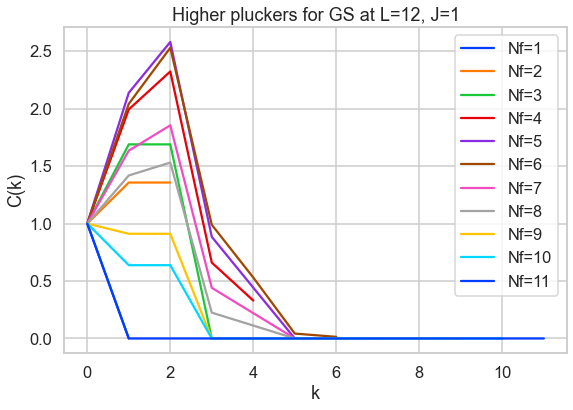

In [119]:
J = 1
L = 12
label = "bulk"

cwd = os.getcwd()
destdir = cwd + '/' +  folder_for_data
files = [ f for f in os.listdir(destdir) if os.path.isfile(os.path.join(destdir,f)) ]

if label=="GS":
    Plucker_files = [f for f in files if f[0] == 'P' and f[8]=='G' and int(f[f.find("L=")+2:f.find("_Nf")]) == L and int(f[f.find("J=")+2:f.find("_L")]) == J] #for GS b-> G
if label=="bulk":
    Plucker_files = [f for f in files if f[0] == 'P' and f[8]=='b' and int(f[f.find("L=")+2:f.find("_Nf")]) == L and int(f[f.find("J=")+2:f.find("_L")]) == J] #for GS b-> G


for Nf in range(1, L+1):
    P = np.zeros(Nf+1)
    counter = 0
    for file in Plucker_files:
        ind1 = file.find("Nf=")
        ind2 = file[ind1+3:].find("_")
        if int(file[ind1 + 3:][:ind2]) == Nf: 
            #print(file)
            counter += 1
            with open(folder_for_data + file, 'rb') as f:
                Pluckers_temp = pickle.load(f)
                P = P + np.array(Pluckers_temp)
    if counter > 0:
        plt.plot(range(len(P)), P/counter, label='Nf={}'.format(Nf));

plt.title("Higher pluckers for {} at L={}, J={}".format(label, L, J))
plt.xlabel("k")
plt.legend()
plt.ylabel("C(k)")
plt.show()

## Entanglement entropy

In [ ]:
number_of_realizations = 3
L = 12
Nf = L//2
J = 1
label = 'GS'

if label== 'GS':
    level = 0
    
    filename_entropies_gen = folder_for_data + 'Entropies_GS_J={}_L={}_Nf={}'.format(J, L, Nf)
    
    for realization in range(number_of_realizations):
        print('It is {} realization'.format(realization))
        basis, E, V = solve_SYK_Hamiltonian(L, Nf, J, 0)
        
        S = []
        for k in range(1, L): #sub-sys size
            sites = [i for i in range(k)]
            ent_val = basis.ent_entropy(np.transpose(V)[level], sub_sys_A=sites, return_rdm='both', return_rdm_EVs='True')
            S.append(k * ent_val['Sent_A'])

        identifyer = random.randint(0, 1000000000)
        filename_Entropy = filename_entropies_gen  + '_{}.pkl'.format(identifyer)
        with open(filename_Entropy, 'wb') as f_S:
            pickle.dump(S, f_S)
            
if label== 'bulk':
    
    basis = spinless_fermion_basis_1d(L=L,Nf=Nf)
    level = basis.Ns//2
    filename_entropies_gen = folder_for_data + 'Entropies_bulk_J={}_L={}_Nf={}'.format(J, L, Nf)
    
    for realization in range(number_of_realizations):
        print('It is {} realization'.format(realization))
        basis, E, V = solve_SYK_Hamiltonian(L, Nf, J, 0)
        
        S = []
        for k in range(1, L): #sub-sys size
            sites = [i for i in range(k)]
            ent_val = basis.ent_entropy(np.transpose(V)[level], sub_sys_A=sites, return_rdm='both', return_rdm_EVs='True')
            S.append(k * ent_val['Sent_A'])

        identifyer = random.randint(0, 1000000000)
        filename_Entropy = filename_entropies_gen  + '_{}.pkl'.format(identifyer)
        with open(filename_Entropy, 'wb') as f_S:
            pickle.dump(S, f_S)

It is 0 realization
It is 1 realization
It is 2 realization


#### Reading out and averaging

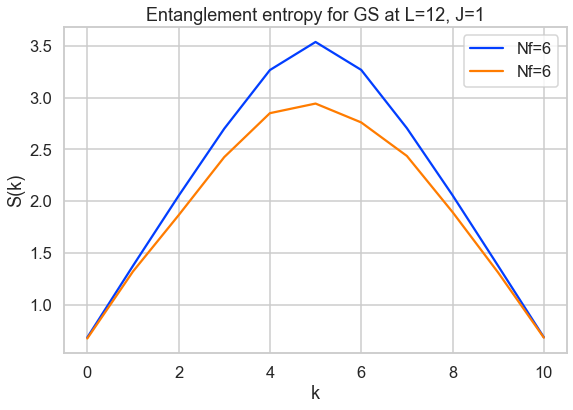

In [148]:
L = 12
Nf = L//2
J = 1
label = "bulk"

cwd = os.getcwd()
destdir = cwd + '/' +  folder_for_data
files = [ f for f in os.listdir(destdir) if os.path.isfile(os.path.join(destdir,f)) ]


if label=="GS":
    Entropy_files = [f for f in files if f[0] == 'E' and f[10]=='G' and int(f[f.find("L=")+2:f.find("_Nf")]) == L and int(f[f.find("J=")+2:f.find("_L")]) == J and int(f[f.find("Nf=")+3:][:f[f.find("Nf=")+3:].find("_")]) == Nf] 

if label=="bulk":
    Entropy_files = [f for f in files if f[0] == 'E' and f[10]=='b' and int(f[f.find("L=")+2:f.find("_Nf")]) == L and int(f[f.find("J=")+2:f.find("_L")]) == J and int(f[f.find("Nf=")+3:][:f[f.find("Nf=")+3:].find("_")]) == Nf] 

S = np.zeros(L-1)

for file in Entropy_files:
    with open(folder_for_data + file, 'rb') as f:
        Entropy_temp = pickle.load(f)
        S = S + np.array(Entropy_temp)


plt.plot(range(len(S)), S/len(Entropy_files), label='Nf={}'.format(Nf));
plt.title("Entanglement entropy for {} at L={}, J={}".format(label, L, J))
plt.xlabel("k")
plt.legend()
plt.ylabel("S(k)")
plt.show() 

# Entropy versus Plucker

In [113]:
L = 10
Nf = L//2
J = 1
label = "bulk"

cwd = os.getcwd()
destdir = cwd + '/' +  folder_for_data
files = [ f for f in os.listdir(destdir) if os.path.isfile(os.path.join(destdir,f)) ]

if label=="GS":
    Entropy_files = [f for f in files if f[0] == 'E' and f[10]=='G' and int(f[f.find("L=")+2:f.find("_Nf")]) == L and int(f[f.find("J=")+2:f.find("_L")]) == J and int(f[f.find("Nf=")+3:][:f[f.find("Nf=")+3:].find("_")]) == Nf] 
    Plucker_files = [f for f in files if f[0] == 'P' and f[8]=='G' and int(f[f.find("L=")+2:f.find("_Nf")]) == L and int(f[f.find("J=")+2:f.find("_L")]) == J and int(f[f.find("Nf=")+3:][:f[f.find("Nf=")+3:].find("_")]) == Nf] 
if label=="bulk":
    Entropy_files = [f for f in files if f[0] == 'E' and f[10]=='b' and int(f[f.find("L=")+2:f.find("_Nf")]) == L and int(f[f.find("J=")+2:f.find("_L")]) == J and int(f[f.find("Nf=")+3:][:f[f.find("Nf=")+3:].find("_")]) == Nf] 
    Plucker_files = [f for f in files if f[0] == 'P' and f[8]=='b' and int(f[f.find("L=")+2:f.find("_Nf")]) == L and int(f[f.find("J=")+2:f.find("_L")]) == J and int(f[f.find("Nf=")+3:][:f[f.find("Nf=")+3:].find("_")]) == Nf]     

    
S = np.zeros(L-1)
for file in Entropy_files:
    with open(folder_for_data + file, 'rb') as f:
        Entropy_temp = pickle.load(f)
        S = S + np.array(Entropy_temp)
      

P = np.zeros(Nf+1)
for file in Plucker_files:
    with open(folder_for_data + file, 'rb') as f:
        Pluckers_temp = pickle.load(f)
        P = P + np.array(Pluckers_temp)

#### Plotting

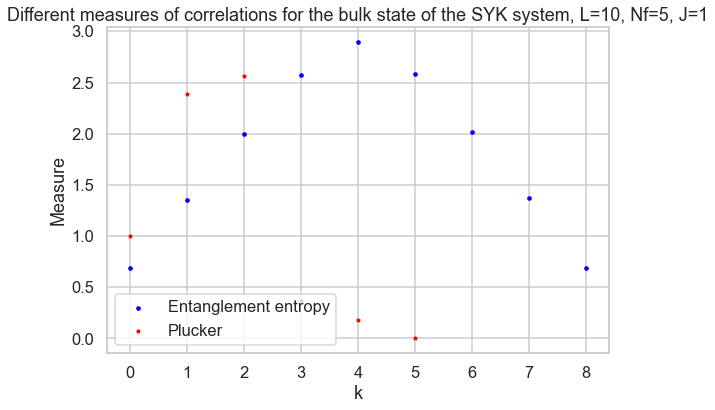

In [114]:
plt.scatter(range(len(S)), S/len(Entropy_files), s=10, marker = 'o', color = 'blue', label = 'Entanglement entropy');
plt.scatter(range(len(P)), P/len(Plucker_files), s=10, marker = '*',color = 'red',  label = 'Plucker');
plt.title("Different measures of correlations for the {} state of the SYK system, L={}, Nf={}, J={}".format(label, L, Nf, J))
plt.xlabel("k")
plt.ylabel("Measure")
plt.legend(loc='lower left')